Explained variance ratio: [0.18445868 0.1239559 ]


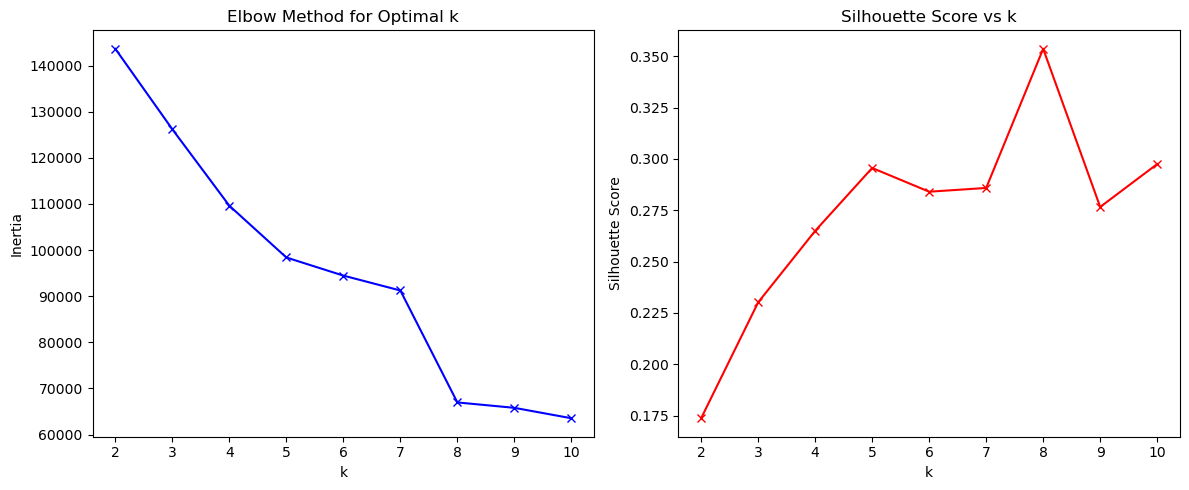


Optimal number of clusters (k): 8


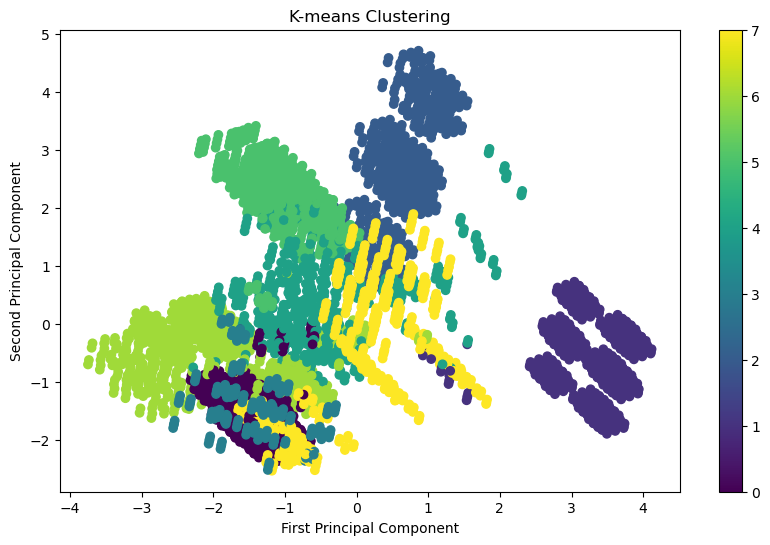

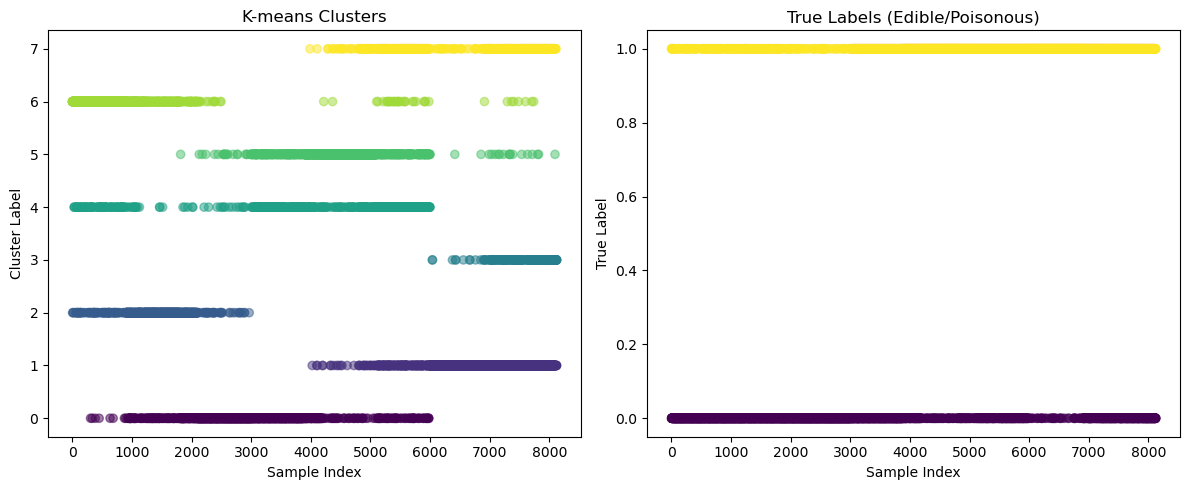

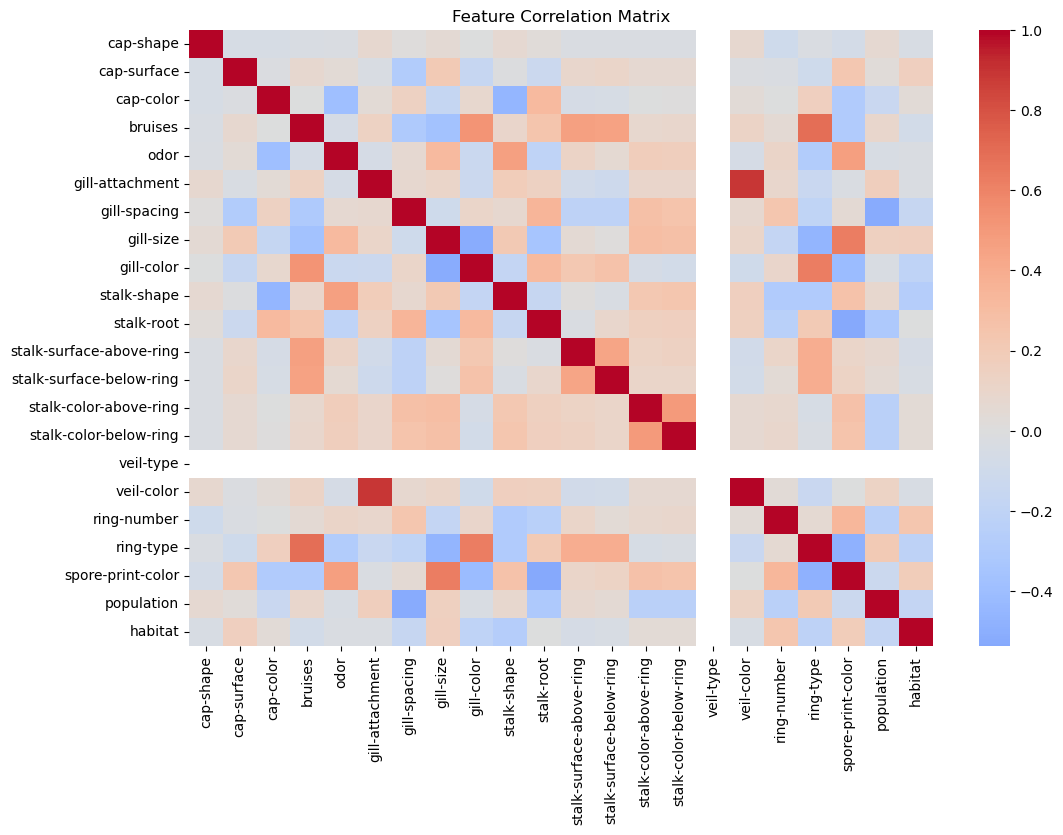

In [17]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load and preprocess data
def preprocess_data(df):
    # Remove the class column for unsupervised learning
    X = df.drop('class', axis=1)
    
    # Keep the class column for later evaluation
    true_labels = df['class']
    
    # Encode categorical variables
    le = LabelEncoder()
    X_encoded = X.apply(le.fit_transform)
    
    # Scale the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_encoded)
    
    return X_scaled, X_encoded, true_labels

# Perform PCA
def perform_pca(X_scaled):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    
    # Calculate explained variance
    explained_variance = pca.explained_variance_ratio_
    
    return X_pca, explained_variance

# K-means clustering with elbow method
def kmeans_clustering(X_scaled):
    inertias = []
    silhouette_scores = []
    K = range(2, 11)
    
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X_scaled)
        inertias.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))
    
    # Plot elbow curve
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(K, inertias, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Inertia')
    plt.title('Elbow Method for Optimal k')
    
    plt.subplot(1, 2, 2)
    plt.plot(K, silhouette_scores, 'rx-')
    plt.xlabel('k')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score vs k')
    
    plt.tight_layout()
    plt.show()
    
    # Get optimal k based on silhouette score
    optimal_k = K[np.argmax(silhouette_scores)]
    
    # Perform final clustering with optimal k
    kmeans = KMeans(n_clusters=optimal_k, random_state=42)
    cluster_labels = kmeans.fit_predict(X_scaled)
    
    return cluster_labels, optimal_k

# Visualize clusters
def plot_clusters(X_pca, labels, title):
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis')
    plt.colorbar(scatter)
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.title(title)
    plt.show()

# Compare clustering with true labels
def compare_with_true_labels(cluster_labels, true_labels, algorithm_name):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.scatter(range(len(cluster_labels)), cluster_labels, c=cluster_labels, cmap='viridis', alpha=0.5)
    plt.title(f'{algorithm_name} Clusters')
    plt.xlabel('Sample Index')
    plt.ylabel('Cluster Label')
    
    plt.subplot(1, 2, 2)
    le = LabelEncoder()
    true_labels_encoded = le.fit_transform(true_labels)
    plt.scatter(range(len(true_labels_encoded)), true_labels_encoded, c=true_labels_encoded, cmap='viridis', alpha=0.5)
    plt.title('True Labels (Edible/Poisonous)')
    plt.xlabel('Sample Index')
    plt.ylabel('True Label')
    
    plt.tight_layout()
    plt.show()

# Main analysis function
def perform_unsupervised_analysis(df):
    # Preprocess data
    X_scaled, X_encoded, true_labels = preprocess_data(df)
    
    # Perform PCA
    X_pca, explained_variance = perform_pca(X_scaled)
    print(f"Explained variance ratio: {explained_variance}")
    
    # K-means clustering
    kmeans_labels, optimal_k = kmeans_clustering(X_scaled)
    print(f"\nOptimal number of clusters (k): {optimal_k}")
    
    # Visualize results
    plot_clusters(X_pca, kmeans_labels, 'K-means Clustering')
    
    # Compare with true labels
    compare_with_true_labels(kmeans_labels, true_labels, 'K-means')
    
    # Feature correlation analysis
    correlation_matrix = X_encoded.corr()
    plt.figure(figsize=(12, 8))
    sns.heatmap(correlation_matrix, cmap='coolwarm', center=0)
    plt.title('Feature Correlation Matrix')
    plt.show()

# Example usage
if __name__ == "__main__":
    # Load your data (adjust the path as needed)
    df = pd.read_csv('mushrooms.csv')
    perform_unsupervised_analysis(df)

Loading and preprocessing images...


100%|██████████| 156/156 [00:00<00:00, 758.49it/s]


Performing PCA analysis...
Computing covariance matrix...
Computing eigenvalues and eigenvectors...
Plotting results...


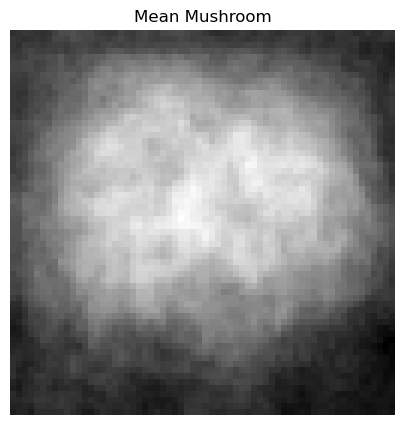

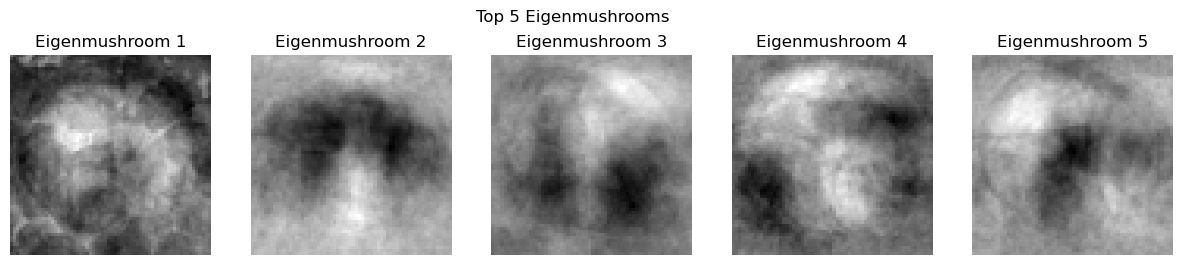

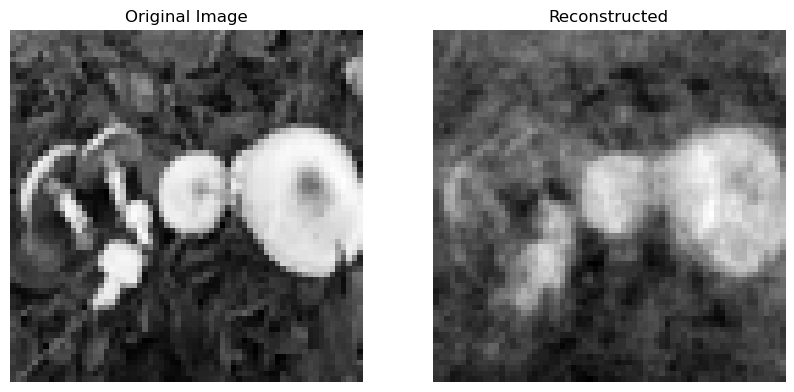

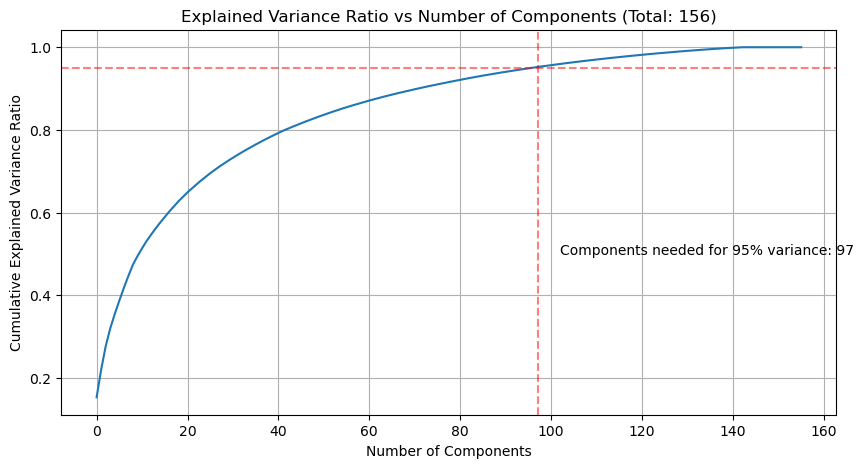

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from PIL import Image
import os
from tqdm import tqdm

def load_and_preprocess_images(folder_path, target_size=(64, 64)):
    """
    Load images from folder, convert to grayscale, resize, and flatten
    """
    images = []
    for filename in tqdm(os.listdir(folder_path)):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            # Load image
            img_path = os.path.join(folder_path, filename)
            img = Image.open(img_path)
            
            # Convert to grayscale
            img = img.convert('L')
            
            # Resize
            img = img.resize(target_size)
            
            # Convert to numpy array and flatten
            img_array = np.array(img).flatten()
            images.append(img_array)
    
    return np.array(images).T  # Each column is one image

def eigsort(V, eigvals):
    # Convert to real if complex
    eigvals = np.real(eigvals)  # Take real part of eigenvalues
    
    # Sort by magnitude of eigenvalues
    lohival = np.sort(eigvals)
    lohiindex = np.argsort(eigvals)
    lambd = np.flip(lohival)
    index = np.flip(lohiindex)
    Dsort = np.diag(lambd)
    
    M = np.size(lambd)
    Vsort = np.zeros((M, M), dtype=np.float64)  # Explicitly create real array
    for i in range(M):
        Vsort[:,i] = np.real(V[:,index[i]])  # Take real part of eigenvectors
    
    return Vsort, Dsort

def view_mushroom(columnvector, image_size):
    """
    Display a mushroom image from its flattened form
    """
    plt.figure()
    plt.imshow(columnvector.reshape(image_size), cmap='gray')
    plt.axis('off')

def perform_pca_analysis(images, image_size, n_components=50):
    # Calculate mean image
    mean_mushroom = np.mean(images, axis=1, keepdims=True)
    
    # Center the data
    A = images - np.repeat(mean_mushroom, images.shape[1], axis=1)
    
    # Compute covariance matrix
    print("Computing covariance matrix...")
    ATA = A.T @ A
    
    # Ensure matrix is symmetric (to avoid numerical issues)
    ATA = (ATA + ATA.T) / 2
    
    # Compute eigenvalues and eigenvectors
    print("Computing eigenvalues and eigenvectors...")
    eigvals, V_old = np.linalg.eig(ATA)
    V, D = eigsort(V_old, eigvals)
    
    # Compute the actual eigenvectors of the covariance matrix
    U = A @ V
    U = normalize(U, norm='l2', axis=0)
    
    # Keep only the top n_components
    U_reduced = U[:, :n_components]
    
    return mean_mushroom, U, U_reduced, D

def plot_analysis_results(images, mean_mushroom, U, U_reduced, D, image_size):
    """
    Plot all analysis results in sequence with pauses
    """
    # 1. Plot mean mushroom
    plt.figure(figsize=(5, 5))
    plt.title('Mean Mushroom')
    plt.imshow(mean_mushroom.reshape(image_size), cmap='gray')
    plt.axis('off')
    plt.show(block=False)
    plt.pause(2)  # Pause to show the image
    
    # 2. Plot top eigenmushrooms
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    fig.suptitle('Top 5 Eigenmushrooms')
    for i in range(5):
        ax = axes[i]
        eigenmushroom = U[:, i].real
        ax.imshow(eigenmushroom.reshape(image_size), cmap='gray')
        ax.axis('off')
        ax.set_title(f'Eigenmushroom {i+1}')
    plt.show(block=False)
    plt.pause(2)
    
    # 3. Plot original vs reconstructed
    original_image = images[:, 0].reshape(-1, 1)
    reconstructed = U_reduced @ (U_reduced.T @ (original_image - mean_mushroom)) + mean_mushroom
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.imshow(original_image.reshape(image_size), cmap='gray')
    ax1.set_title('Original Image')
    ax1.axis('off')
    
    ax2.imshow(reconstructed.reshape(image_size), cmap='gray')
    ax2.set_title('Reconstructed')
    ax2.axis('off')
    plt.show(block=False)
    plt.pause(2)
    
    # 4. Plot explained variance with all components
    eigvals = np.diag(D).real
    explained_variance_ratio = eigvals / np.sum(eigvals)
    cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
    
    plt.figure(figsize=(10, 5))
    plt.plot(cumulative_variance_ratio)  # Show all components
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.title(f'Explained Variance Ratio vs Number of Components (Total: {len(cumulative_variance_ratio)})')
    plt.grid(True)
    
    # Add vertical line at 95% variance explained
    threshold = 0.95
    components_95 = np.where(cumulative_variance_ratio >= threshold)[0][0] + 1
    plt.axhline(y=threshold, color='r', linestyle='--', alpha=0.5)
    plt.axvline(x=components_95, color='r', linestyle='--', alpha=0.5)
    plt.text(components_95 + 5, 0.5, f'Components needed for 95% variance: {components_95}')
    
    plt.show(block=False)
    plt.pause(2)
    
    # Keep figures open
    plt.show()

def main():
    # Parameters
    IMAGE_SIZE = (64, 64)
    N_COMPONENTS = 50
    FOLDER_PATH = 'imgs/'  # Fixed directory path
    
    print("Loading and preprocessing images...")
    images = load_and_preprocess_images(FOLDER_PATH, IMAGE_SIZE)
    
    # Perform PCA
    print("Performing PCA analysis...")
    mean_mushroom, U, U_reduced, D = perform_pca_analysis(images, IMAGE_SIZE, N_COMPONENTS)
    
    # Plot results
    print("Plotting results...")
    plot_analysis_results(images, mean_mushroom, U, U_reduced, D, IMAGE_SIZE)

if __name__ == "__main__":
    main()

In [12]:
df = pd.read_csv('mushrooms.csv')
df.head()

class cap-shape cap-surface cap-color bruises odor gill-attachment  \
0     p         x           s         n       t    p               f   
1     e         x           s         y       t    a               f   
2     e         b           s         w       t    l               f   
3     p         x           y         w       t    p               f   
4     e         x           s         g       f    n               f   

  gill-spacing gill-size gill-color  ... stalk-surface-below-ring  \
0            c         n          k  ...                        s   
1            c         b          k  ...                        s   
2            c         b          n  ...                        s   
3            c         n          n  ...                        s   
4            w         b          k  ...                        s   

  stalk-color-above-ring stalk-color-below-ring veil-type veil-color  \
0                      w                      w         p          w   
1                      w                      w         p          w   
2                      w                      w         p          w   
3                      w                      w         p          w   
4                      w                      w         p          w   

  ring-number ring-type spore-print-color population habitat  
0           o         p                 k          s       u  
1           o         p                 n          n       g  
2           o         p                 n          n       m  
3           o         p                 k          s       u  
4           o         e                 n          a       g  

[5 rows x 23 columns]

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises                   8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                8124 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14  stalk-color-above-ring  

In [14]:
df.isna().sum().sum()

0

In [16]:
color_features = []
for i in df.columns:
    if 'color' in i:
        color_features.append(i)
# create our color dataframe and inspect first 5 rows with head()
data_color = df[color_features]
data_color.head()

cap-color gill-color stalk-color-above-ring stalk-color-below-ring  \
0         n          k                      w                      w   
1         y          k                      w                      w   
2         w          n                      w                      w   
3         w          n                      w                      w   
4         g          k                      w                      w   

  veil-color spore-print-color  
0          w                 k  
1          w                 n  
2          w                 n  
3          w                 k  
4          w                 n

In [19]:
from sklearn.preprocessing import LabelEncoder
# List to store all unique categories
ListToEncode = pd.Series(data_color.values.ravel()).unique()
# Use sklearn Labelencoder for transformation
EncodedList = LabelEncoder().fit_transform(ListToEncode)

# Define a dictionary "encodedict" to store our encoding
encodedict = {}
for i in range(0, len(EncodedList)):
    encodedict.update({ListToEncode[i]:EncodedList[i]})

# Finally use dictionary to generate encoded dataframe
for i in range(len(data_color.columns)):
    for j in range(len(data_color['cap-color'].values)):
        data_color.values[j][i] =  encodedict[data_color.values[j][i]]
data_color.head()  
# correlation matrix using the corr() method
data_corr = data_color.astype(float).corr()  # used the astype() or else I get empty results
data_corr

cap-color  gill-color  stalk-color-above-ring  \
cap-color                1.000000    0.097253                0.089248   
gill-color               0.097253    1.000000               -0.058458   
stalk-color-above-ring   0.089248   -0.058458                1.000000   
stalk-color-below-ring   0.093015   -0.074540                0.509303   
veil-color              -0.001314   -0.107792                0.079030   
spore-print-color       -0.233534   -0.474733                0.225851   

                        stalk-color-below-ring  veil-color  spore-print-color  
cap-color                             0.093015   -0.001314          -0.233534  
gill-color                           -0.074540   -0.107792          -0.474733  
stalk-color-above-ring                0.509303    0.079030           0.225851  
stalk-color-below-ring                1.000000    0.077198           0.209170  
veil-color                            0.077198    1.000000           0.036781  
spore-print-color                     0.209170    0.036781           1.000000

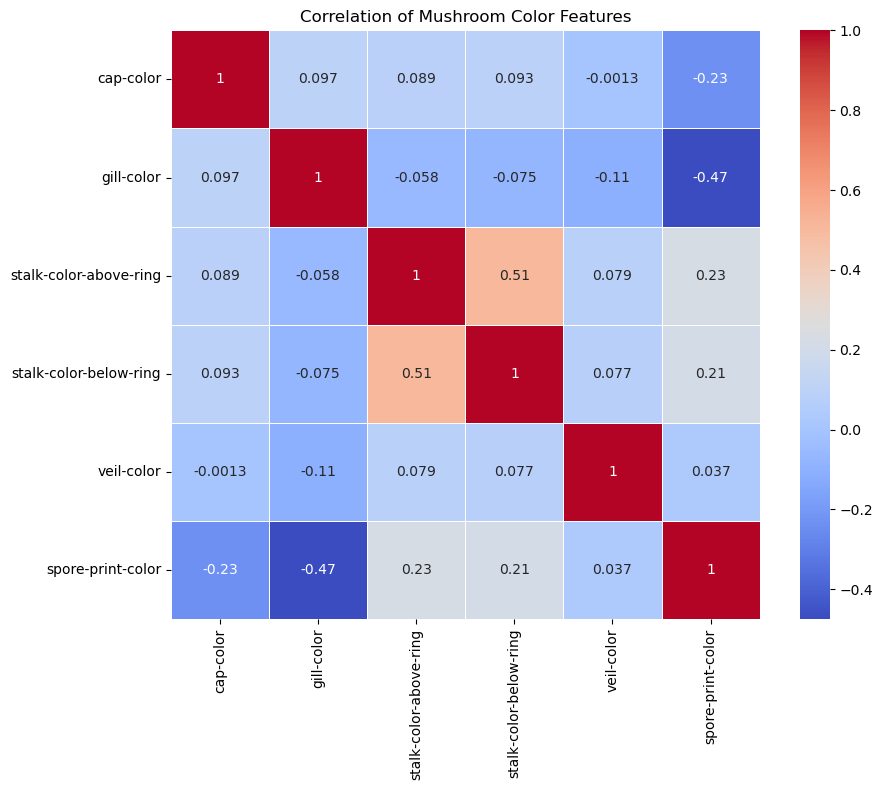

In [29]:
# Plot correlation heatmap
plt.figure(figsize=(10, 8))
plt.title('Correlation of Mushroom Color Features')
sns.heatmap(data_corr, linewidths=0.5, vmax=1.0, square=True, annot=True, cmap='coolwarm')
plt.tight_layout()
plt.show()

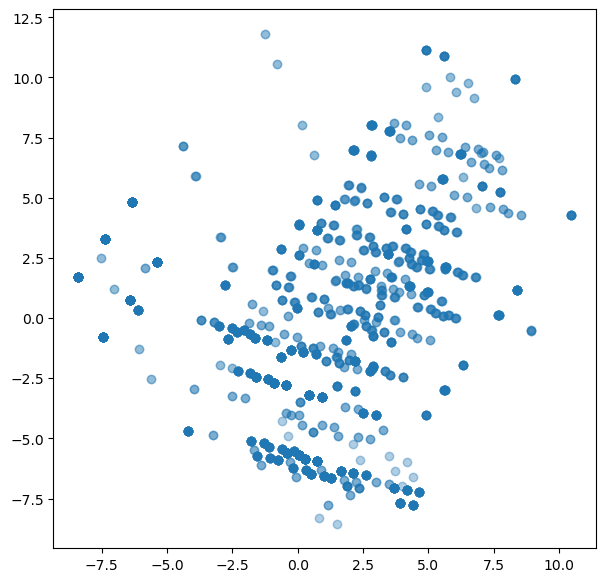

In [22]:
X = data_color.values
# calling sklearn PCA 
pca = PCA(n_components=3)
# fit X and apply the reduction to X 
x_3d = pca.fit_transform(X)

plt.figure(figsize = (7,7))
plt.scatter(x_3d[:,0],x_3d[:,1], alpha=0.1)
plt.show()

In [23]:
# Set a 3 KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=0)
# Compute cluster centers and predict cluster indices
X_clustered = kmeans.fit_predict(x_3d)

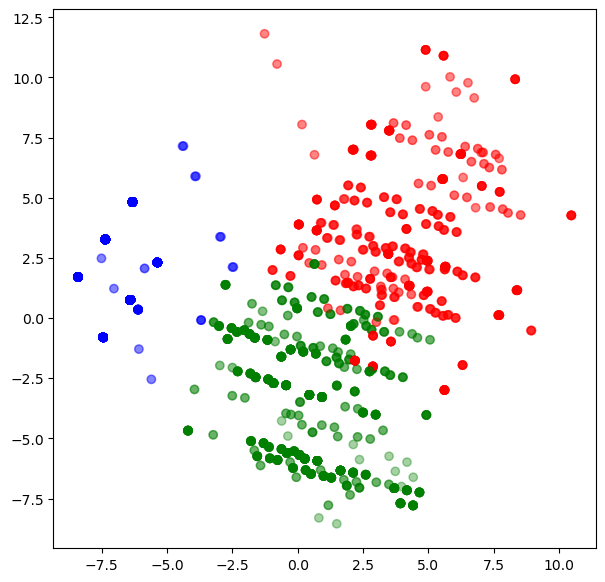

In [24]:
LABEL_COLOR_MAP = {0 : 'r',
                   1 : 'g',
                   2 : 'b'}

label_color = [LABEL_COLOR_MAP[l] for l in X_clustered]
plt.figure(figsize = (7,7))
plt.scatter(x_3d[:,0],x_3d[:,1], c= label_color, alpha=0.1)
plt.show()